In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re

In [14]:
nhs_2011 = pd.read_csv("../data/raw/99-004-XWE2011001-401-BC.csv", encoding='latin-1', usecols=[0,2,3,4,5,6,8,10,12])
nhs_2011

,Geo_Code,CMA_CA_Name,CT_Name,GNR,Topic,Characteristic,Total,Male,Female
0,9150102.04,Kelowna,102.04,36.2,Citizenship,Total population in private households by citi...,5820.0,2745.0,3070.0
1,9150102.04,Kelowna,102.04,36.2,Citizenship,Canadian citizens,5665.0,2685.0,2980.0
2,9150102.04,Kelowna,102.04,36.2,Citizenship,Canadian citizens aged under 18,800.0,400.0,395.0
3,9150102.04,Kelowna,102.04,36.2,Citizenship,Canadian citizens aged 18 and over,4875.0,2285.0,2590.0
4,9150102.04,Kelowna,102.04,36.2,Citizenship,Not Canadian citizens,150.0,60.0,90.0
...,...,...,...,...,...,...,...,...,...
510618,9330181.09,Vancouver,181.09,21.3,Income of individuals in 2010,Median employment income in 2010 ($),74974.0,89766.0,59757.0
510619,9330181.09,Vancouver,181.09,21.3,Income of individuals in 2010,Average employment income in 2010 ($),101753.0,123599.0,68020.0
510620,9330181.09,Vancouver,181.09,21.3,Income of individuals in 2010,Family income in 2010 of economic families,1875.0,NaN,NaN
510621,9330181.09,Vancouver,181.09,21.3,Income of individuals in 2010,Median family income ($),123597.0,NaN,NaN


In [23]:
van_nhs_2011 = nhs_2011[nhs_2011['CMA_CA_Name'] == 'Vancouver']
van_nhs_2011

,Geo_Code,CMA_CA_Name,CT_Name,GNR,Topic,Characteristic,Total,Male,Female
128640,9330187.11,Vancouver,187.11,19.6,Citizenship,Total population in private households by citi...,4805.0,2360.0,2445.0
128641,9330187.11,Vancouver,187.11,19.6,Citizenship,Canadian citizens,3985.0,2015.0,1965.0
128642,9330187.11,Vancouver,187.11,19.6,Citizenship,Canadian citizens aged under 18,1070.0,605.0,465.0
128643,9330187.11,Vancouver,187.11,19.6,Citizenship,Canadian citizens aged 18 and over,2920.0,1415.0,1505.0
128644,9330187.11,Vancouver,187.11,19.6,Citizenship,Not Canadian citizens,815.0,345.0,475.0
...,...,...,...,...,...,...,...,...,...
510618,9330181.09,Vancouver,181.09,21.3,Income of individuals in 2010,Median employment income in 2010 ($),74974.0,89766.0,59757.0
510619,9330181.09,Vancouver,181.09,21.3,Income of individuals in 2010,Average employment income in 2010 ($),101753.0,123599.0,68020.0
510620,9330181.09,Vancouver,181.09,21.3,Income of individuals in 2010,Family income in 2010 of economic families,1875.0,NaN,NaN
510621,9330181.09,Vancouver,181.09,21.3,Income of individuals in 2010,Median family income ($),123597.0,NaN,NaN


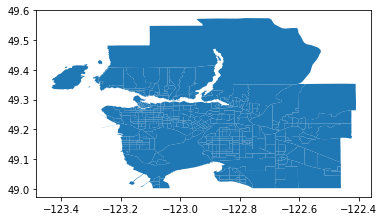

In [9]:
data = gpd.read_file("../data/raw/gct_000b11a_e.shp")
van_bound = data[data['CMANAME'] == 'Vancouver']
van_bound.plot()